In [1]:
import kaggle_functions as kaggle
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np

In [2]:
train_dataset, test_dataset= kaggle.load_train_as_dataset()
x_test_real = kaggle.load_test_set()
_, _, _, _, _, test_true = kaggle.load_train_set()

### AlexNet

In [13]:
l2_reg = 0.0025

# Create Convnet
model = keras.models.Sequential([
    # Input layer indicates image size as height, width, channels
    keras.layers.InputLayer((96,96,1)),

    # Data augmentation layers
    keras.layers.RandomFlip(),
    keras.layers.RandomZoom(-0.3),
    keras.layers.RandomContrast(0.3),
    #keras.layers.RandomRotation(0.1),

    # Series of convolutional levels with pooling
    # Layers get deeper (more filters), but with smaller 2D matrices in each
    keras.layers.Conv2D(
        filters=64, strides=(2,2), kernel_size=(11,11), padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), 
        activation='relu', kernel_initializer=keras.initializers.HeNormal),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Conv2D(
        filters=192, kernel_size=(3,3), padding='same', 
        activation='relu', kernel_initializer=keras.initializers.HeNormal),
    keras.layers.Dropout(0.05),
    keras.layers.Conv2D(
        filters=192, kernel_size=(3,3), padding='same', 
        activation='relu', kernel_initializer=keras.initializers.HeNormal),
    keras.layers.Dropout(0.1),
    keras.layers.Conv2D(
        filters=128, kernel_size=(3,3), padding='same', 
        activation='relu', kernel_initializer=keras.initializers.HeNormal),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten at the end to predict final labels
    keras.layers.Flatten(),
    keras.layers.Dense(
        512, activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(
        512, activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(11)
])
model.summary()

# Compile model
model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.0001), # default is 0.001
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Early stopping
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
]

# Fit model
history = model.fit(
    train_dataset.batch(32).cache(), 
    validation_data=test_dataset.batch(32).cache(),
    epochs=200, callbacks=callbacks, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 96, 96, 1)         0         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 96, 96, 1)         0         
                                                                 
 random_contrast_2 (RandomCo  (None, 96, 96, 1)        0         
 ntrast)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        7808      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 22, 22, 128)      

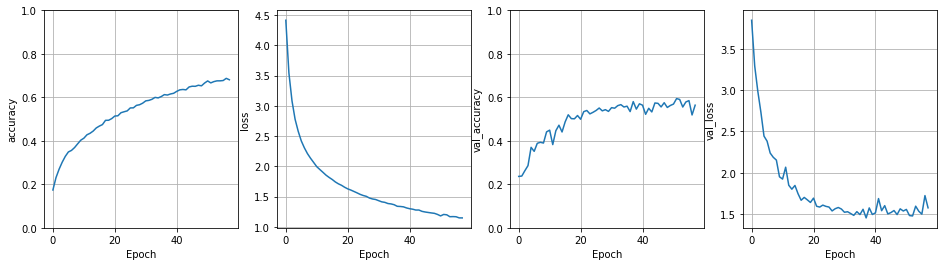

In [8]:
kaggle.plot_model_history(
    history, ['accuracy', 'loss', 'val_accuracy', 'val_loss'])

F1-micro: 0.5639, accuracy: 0.5639


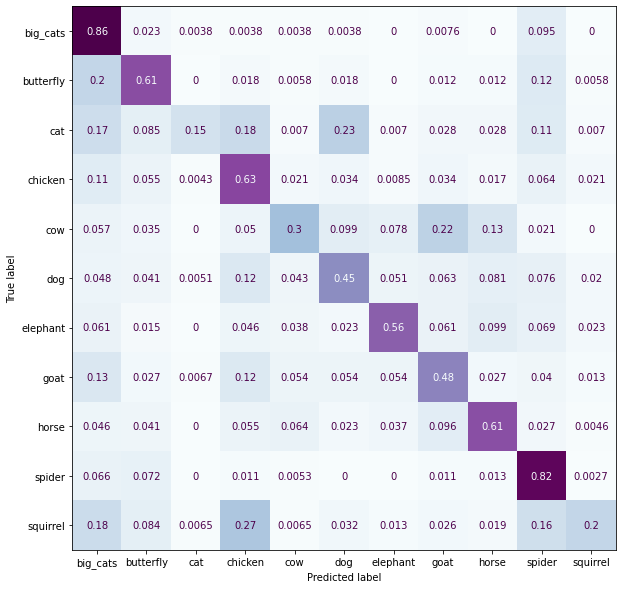

In [12]:
import importlib
importlib.reload(kaggle)

test_pred = np.argmax(model.predict(test_dataset.batch(128)), axis=1)

kaggle.print_accuracy(test_pred, test_true)
kaggle.plot_confusion_matrix(test_true, test_pred)